<a href="https://colab.research.google.com/github/Ronlin1/AgriGeoSustain/blob/main/AgriGeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'food-crisis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3953602%2F6881240%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240308%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240308T140057Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D554422e64d17f10e3c5495ad5ff7dc9e04e150bf8be78400f008e1af79e78c1abf800c6a7049f2934f84c3321447e1af4f4ae8574b63b493cd893b59ee6f82a727b8746b22121826f2e37b824c190dd78fc6879fdb914a2bcc348467886e3a6af1b29a6aff42ba450a61bfa0ca449cba81972756efaccd5d3c5181b9bf5ed1d4d40bc52da23cd9e7fcdf3136ec744dd2768920d76068e68e1b14b522f5cce8335d4e828a6cfdb14a1708dcc27abae52177bacdb629bcfb50493973e4e22698c54ce0c52668b91c237985e406294629254ab5d94efe1da1756493352351f462734a716d1158fdd07eb13c4e66605ced21a6880af34ff40c745a9f4a171e99d4bf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7744136 bytes downloaded
Downloaded and uncompressed: food-crisis
Data source import complete.


In [2]:
# Import necessary libraries
import pandas as pd

# Load the original CSV file
original_data = pd.read_csv('/kaggle/input/food-crisis/predicting_food_crises_data.csv')  # Replace with your file path

# Filter the DataFrame to include only Uganda data
uganda_data = original_data[original_data['country'] == 'Uganda']  # Updated column name

# Save the filtered data to a new CSV file
uganda_data.to_csv('uganda_data.csv', index=False)  # Replace 'uganda_data.csv' with your desired file name
print("Done creating the file")

Done creating the file


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Load your dataset from the CSV file
data = pd.read_csv('uganda_data.csv')  # Replace with your dataset file path

# Define the features (X) and the target variable (y)
# Replace these with the actual column names from your dataset
features = ['year', 'month', 'ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'p_staple_food', 'area', 'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct']
target_variable = 'fews_ipc'  # Replace with the name of your target variable

X = data[features]

# Handle missing values in the target variable
imputer = SimpleImputer(strategy='mean')
y = imputer.fit_transform(data[target_variable].values.reshape(-1, 1))

# Split the data into a training set and a testing set (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

import joblib

# Save the model
joblib.dump(model, 'agrigeo_model.pkl')


Mean Squared Error: 0.02982165218375694
R-squared: 0.08244475320892553


['agrigeo_model.pkl']

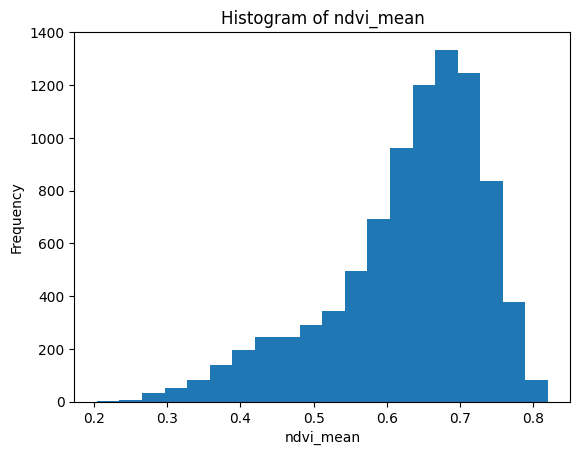

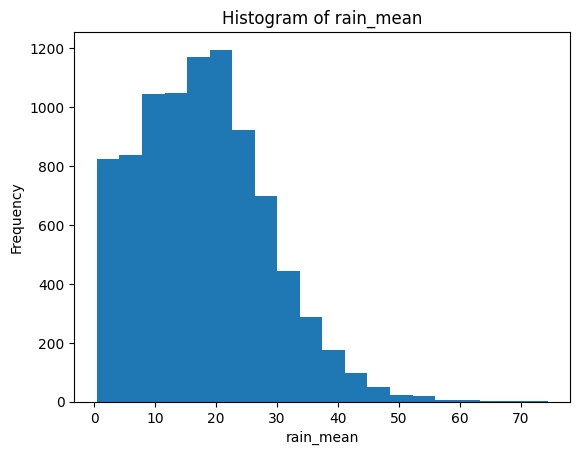

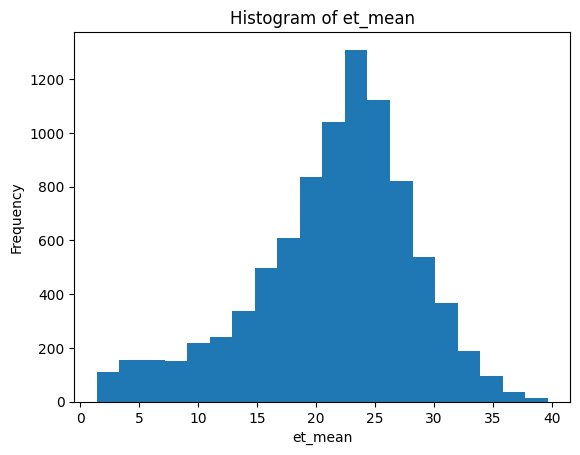

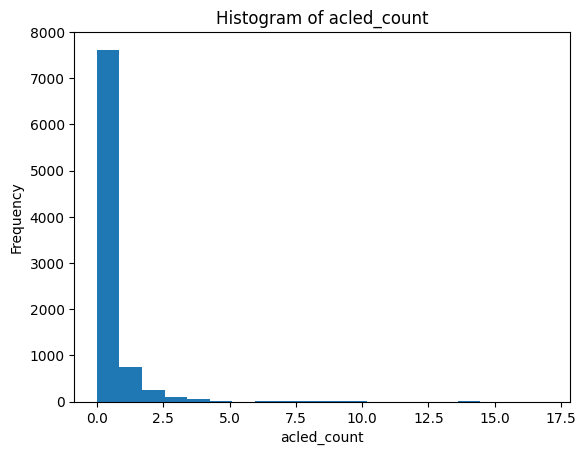

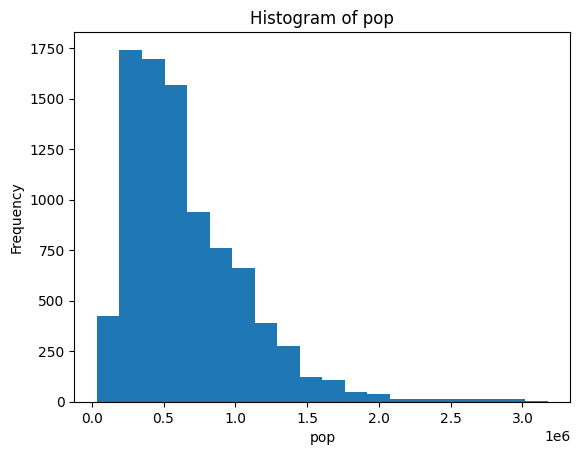

In [4]:
import matplotlib.pyplot as plt

# Plot histograms for selected columns
numeric_columns = ['ndvi_mean', 'rain_mean', 'et_mean', 'acled_count', 'pop']
for column in numeric_columns:
    plt.hist(data[column], bins=20)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()


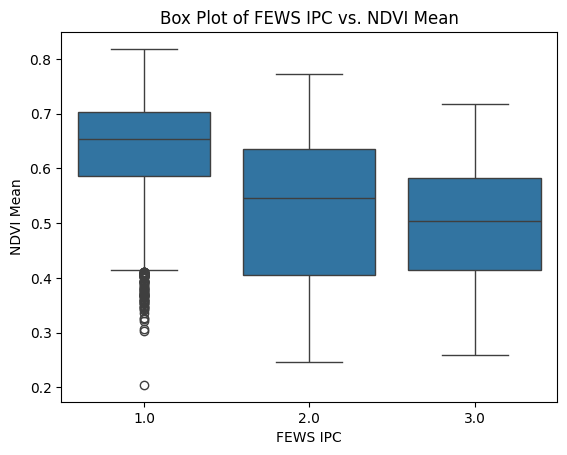

In [5]:
import seaborn as sns

# Create box plots for selected columns
sns.boxplot(x='fews_ipc', y='ndvi_mean', data=data)
plt.xlabel('FEWS IPC')
plt.ylabel('NDVI Mean')
plt.title('Box Plot of FEWS IPC vs. NDVI Mean')
plt.show()


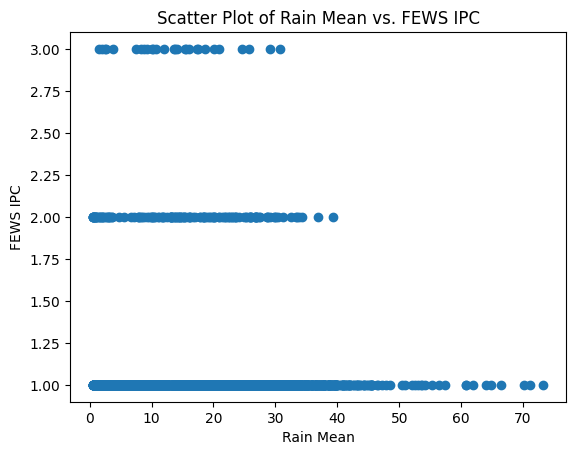

In [6]:
# Create a scatter plot for two numeric variables
plt.scatter(data['rain_mean'], data['fews_ipc'])
plt.xlabel('Rain Mean')
plt.ylabel('FEWS IPC')
plt.title('Scatter Plot of Rain Mean vs. FEWS IPC')
plt.show()


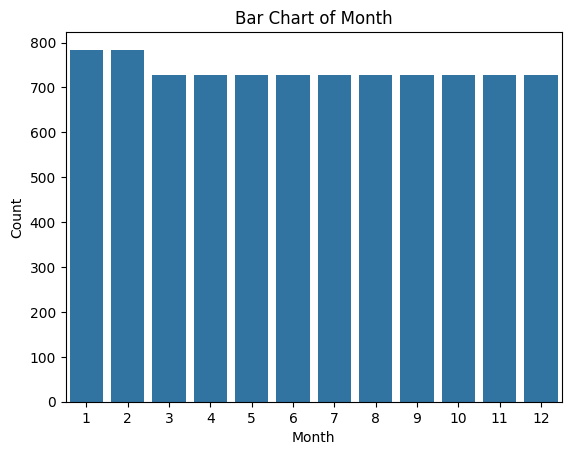

In [7]:
# Create a bar chart for a categorical variable
sns.countplot(x='month', data=data)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Bar Chart of Month')
plt.show()


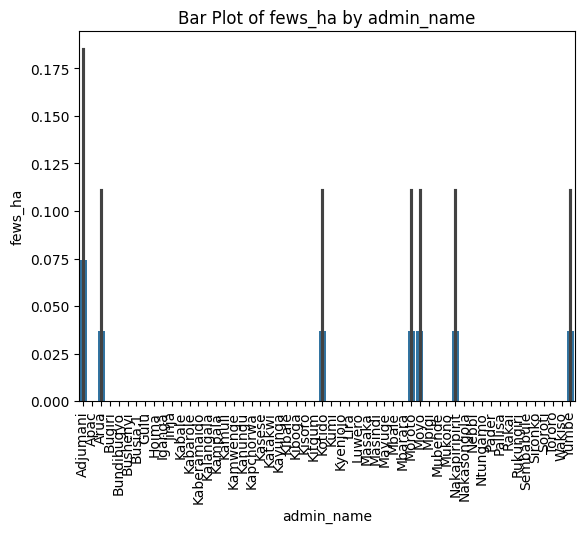

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot for a specific numeric column (e.g., 'fews_ha') based on 'admin_name'
sns.barplot(x='admin_name', y='fews_ha', data=data)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('admin_name')
plt.ylabel('fews_ha')
plt.title('Bar Plot of fews_ha by admin_name')
plt.show()
